In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class LinesDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        self.size = (32,32)
        self.min_lines = 1
        self.max_lines = 4
        
    def __iter__(self):
        return self
        
    def __next__(self):
        h,w = self.size 
        target = torch.zeros(h,w, dtype=torch.long)
        challenge = torch.zeros(h,w, dtype=torch.long)
        num_lines = torch.randint(self.min_lines,self.max_lines+1,()).item()

        line_dx = torch.randint(1,5,(num_lines,)) * torch.randn(num_lines).sign().long()
        line_dy = torch.randint(3,(num_lines,)) - 1
        line_len = torch.randint(min(w,h), (num_lines,))
        colors = torch.randperm(10).add(1)[:num_lines].sort(0)[0]
        
        for dx,dy,ll,color in zip(line_dx, line_dy, line_len, colors):
            if torch.rand(()) > 0.5:
                dx,dy = dy,dx
            ll = max(1,ll//max(abs(dx),abs(dy)))
            lw,lh = (abs(dx * ll).item(), abs(dy * ll).item())
            sx,sy = torch.randint(w-lw,()).item(), torch.randint(h-lh,()).item()
            if dx < 0: sx = w-sx-1
            if dy < 0: sy = h-sy-1
                
            for i in range(ll):
                x0,y0 = min(max(0,sx+dx*i),self.size[1]-1), min(max(0,sy+dy*i),self.size[0]-1)
                x1,y1 = min(max(0,sx+dx*(i+1)),self.size[1]-1), min(max(0,sy+dy*(i+1)),self.size[0]-1)
                x0,x1 = sorted([x0,x1])
                y0,y1 = sorted([y0,y1])
                if x0 == x1: x1 = x0 + 1
                if y0 == y1: y1 = y0 + 1
                target[y0:y1,x0:x1] = color

            x0,x1 = sx,min(max(0,sx+dx*ll),self.size[1]-1)
            y0,y1 = sy,min(max(0,sy+dy*ll),self.size[0]-1)
            if x0 != x1: x1 -= 1
            if y0 != y1: y1 -= 1
            challenge[y0,x0] = color
            challenge[y1,x1] = color
            
            
        return challenge[None], target[None]
        

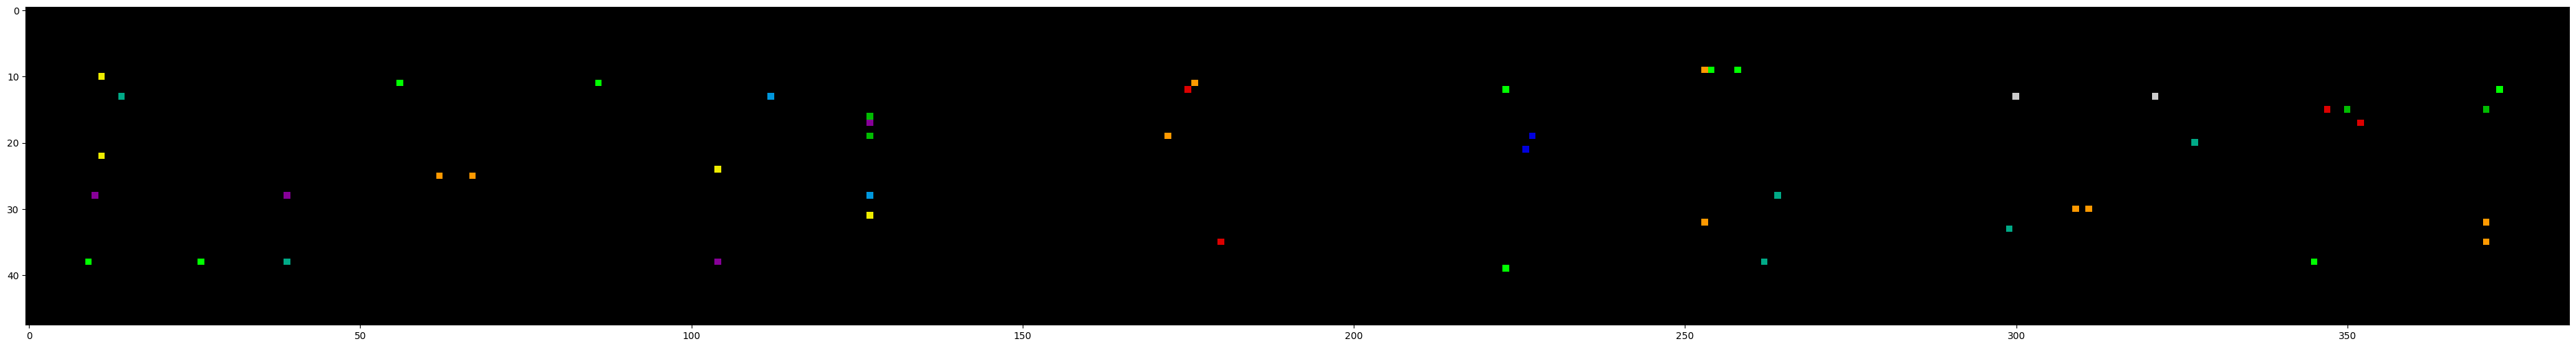

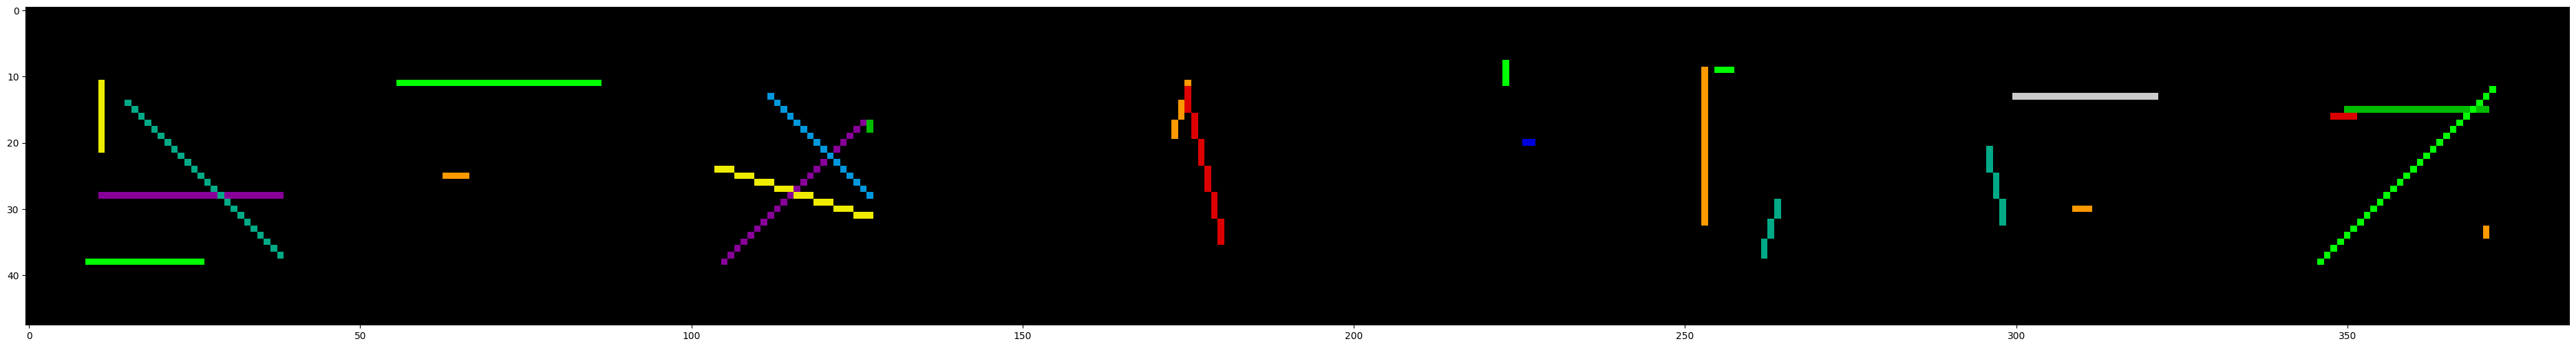

In [6]:
dataset = LinesDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))

batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()
